In [1]:
using ProgressBars;
using ProgressMeter
using LinearAlgebra, Plots, FFTW;
using LoggingExtras, ProgressLogging, Logging, TerminalLoggers
using Infiltrator
import LinearSolve as LS
using SparseArrays
using QuadGK;
using SpecialFunctions: gamma, loggamma, zeta
using CUDA
println("BLAS.get_num_threads(): ", BLAS.get_num_threads())

function central_diff_vec(vec, h)
    vec_ip1 = circshift(vec, -1)
    vec_im1 = circshift(vec, 1)
    return (vec_ip1 - vec_im1) / (2 * h)
end


function m_T_func(x)
    m_T_func_unnorm = (x) -> exp(-(x - 0.5)^2 / (0.1)^2)
    oneOverC, error = quadgk(m_T_func_unnorm, 0, 1) #Why 0, 1? Double check
    return (1 / oneOverC) * m_T_func_unnorm(x)
end

function old_conv_func(m_vec, x_vec, δ)

    old_ϕ_δ = (x, δ) -> 1 / (δ * sqrt(2 * π)) * exp(-x^2 / (2 * δ^2))
    N_h = length(m_vec)
    h = x_vec[2] - x_vec[1]
    conv_vec = Vector{Float64}(undef, N_h)

    Δs = (x_vec .- x_vec[1]) .- round.(x_vec .- x_vec[1])  # (-0.5, 0.5] 

    # Periodic kernel weights and discrete normalization
    weights = old_ϕ_δ.(Δs, δ)
    Z = h * sum(weights)
    weights ./= Z

    # Circular convolution with circulant weights (O(N^2), robust and simple)
    for j in 1:N_h
        s = 0.0
        for i in 1:N_h
            idx = mod(j - i, N_h) + 1  # 1-based index
            s += weights[idx] * m_vec[i]
        end
        conv_vec[j] = h * s
    end
    return conv_vec
end

function Q(x_vec, δ)
    a = 20
    b = 15
    c = 0.97
    σ = 0.03
    Q_1 = ((x) -> 1 / σ * exp(-(x - c)^2 / (4 * σ^2)) + 1 / σ * exp(-(x - c + 1)^2 / (4 * σ^2))).(x_vec)
    base_vec = -a * x_vec .+ b
    Q_2 = old_conv_func(base_vec, x_vec, δ)
    return Q_1 + Q_2
end

function B(M, t_n) # congestion term
    B_ = 0
    cutt = 50
    M < cutt ? B_ = 0.1 * exp(0.5 * M) : B_ = 0.1 * exp.(0.5 * cutt)
    return B_
end

function Fh_func(M_n, t_n, δ, x_grid)
    C_Q = 0.1
    C_B = 1
    Q_term = C_Q * Q(x_grid, δ)
    B_term = C_B * B.(M_n, 2 - t_n)

    return Q_term + B_term
end

function Gh_func(M, x_grid, t_n, δ)
    C_G = 1 / 2
    return C_G * Fh_func(M, t_n, δ, x_grid)
end

function H_func(p, C_H)
    return C_H * p^2
end

function create_mathcalF(x, U_n, PDL_matrix, M_n, Δt, n, h, ν, x_grid, δ, δ_hU, C_H)
    # F_hM_n = Fh_func(M_n, (n - 1) * Δt, δ, x_grid, h) #time was T-nΔt in old code??
    #δ_hx = central_diff_vec(x, h)
    Hδ_hx = H_func.(δ_hU, C_H)
    return x - U_n + Δt * (ν * PDL_matrix * x + Hδ_hx) # - F_hM_n)
end

##########################

# Matrices 

function create_Jacobian(N_h, U, PDL_matrix, Δt, h, ν, δ_hU) # When Hamiltonian H = p^2 / 2
    subdiag = -1 * δ_hU[2:N_h]
    supdiag = δ_hU[1:N_h-1]

    deriv_Ham_δ_hU_mat = zeros(N_h, N_h) + Tridiagonal(subdiag, zeros(N_h), supdiag)
    deriv_Ham_δ_hU_mat[1, end] = -1 * δ_hU[1]
    deriv_Ham_δ_hU_mat[end, 1] = δ_hU[end]

    J_F = 1.0 * I(N_h) + Δt * (ν * PDL_matrix + (1 / (2h)) * deriv_Ham_δ_hU_mat)
    return J_F
end


function create_PDL_matrix(N_h, α, h, R) # new method, spectral method. Verified agains old method, and gives zero row sums.
    k = collect(0:N_h-1)
    λ = (2 .- 2 .* cos.(2π .* k ./ N_h)) .^ (α / 2) ./ h^α  # λ_0 = 0
    # First column of the circulant is the inverse FFT of eigenvalues
    c = real(ifft(λ))                       # first column
    D = zeros(Float64, N_h, N_h)
    for j in 1:N_h
        D[:, j] = circshift(c, j - 1)
    end
    return D
end


#######################

# HJB algorithm
use_gpu = true

function new_HJB_step(num_iter_HJB, N_h, U_n, M_n, PDL_matrix, Δt, h, ν, n, x_grid, δ, C_H, tol=1e-13)
    x_k = U_n

    newton_time = time()
    jacobian_tot_time = 0.0
    mathcalF_tot_time = 0.0
    inverse_tot_time = 0.0

    if use_gpu
        J_F_gpu = CuArray{Float64}(undef, N_h, N_h)
        mathcalF_gpu = CuArray{Float64}(undef, N_h)
    end

    F_hM_n = Fh_func(M_n, (n - 1) * Δt, δ, x_grid) #time was T-nΔt in old code??

    final_k = 0
    for k in 1:num_iter_HJB
        final_k += 1
        #println("k=",k) 
        δ_hU = central_diff_vec(x_k, h)

        J_time = time()
        J_F = create_Jacobian(N_h, x_k, PDL_matrix, Δt, h, ν, δ_hU)
        jacobian_tot_time += time() - J_time

        mathcalF_time = time()
        mathcalFx_k = create_mathcalF(x_k, U_n, PDL_matrix, M_n, Δt, n, h, ν, x_grid, δ, δ_hU, C_H) - Δt * F_hM_n
        mathcalF_tot_time += time() - mathcalF_time

        inverse_time = time()

        if use_gpu
            copy!(J_F_gpu, J_F)
            copy!(mathcalF_gpu, mathcalFx_k)
            δ_k = J_F_gpu \ mathcalF_gpu
            δ_k = Array(δ_k)
        else
            δ_k = J_F \ mathcalFx_k
        end

        inverse_tot_time += time() - inverse_time

        #println("norm δ_k: ", norm(δ_k))

        x_kp1 = x_k - δ_k
        x_k = x_kp1

        δ_k_norm = norm(δ_k)
        if δ_k_norm < tol
            break
        end
        #next!(Newtons_progress)

        #if n > 69
        #@infiltrate
        # end
    end

    newton_time = time() - newton_time

    time_percentages = [newton_time, jacobian_tot_time / newton_time, mathcalF_tot_time / newton_time, inverse_tot_time / newton_time]

    U_np1 = x_k
    return U_np1, time_percentages, final_k
end


#######
function new_HJB_solve(N_h, N_T, M_mat, PDL_matrix, Δt, h, ν, num_iter_HJB, x_grid, δ, C_H)
    U_mat = Array{Float64}(undef, N_h, N_T)
    U_mat[:, 1] = Gh_func(M_mat[:, 1], x_grid, 0, δ)

    #println("Starting HJB_solve ...")
    #HJB_progress = Progress(num_it_MFG, desc="HJB iterations")

    method = ""
    avg_times = [0.0, 0.0, 0.0, 0.0]
    newton_iterations = Float64[]
    hjb_solve_time = time()
    for n in 1:(N_T-1)
        #println("n=",n)
        if method == "explicit"
            U_mat[:, n+1] = explicit_HJB_step(num_iter_HJB, N_h, U_mat[:, n], M_mat[:, n], PDL_matrix, Δt, h, ν, n, x_grid)
        elseif method == "theta"
            U_mat[:, n+1] = imp_exp_HJB_step(num_iter_HJB, N_h, U_mat[:, n], M_mat[:, n], PDL_matrix, Δt, h, ν, n, x_grid)
        else
            U_mat[:, n+1], time_percentages, final_k = new_HJB_step(num_iter_HJB, N_h, U_mat[:, n], M_mat[:, n], PDL_matrix, Δt, h, ν, n, x_grid, δ, C_H)
            #println("n: ", n, "Time and time percentages [N (Newtons), J/N, F/N, inverse/N]: ", time_percentages)
            push!(newton_iterations, final_k)
            avg_times[1] += time_percentages[1]
            avg_times[2] += time_percentages[2]
            avg_times[3] += time_percentages[3]
            avg_times[4] += time_percentages[4]
            #println("avg_time: ", avg_times)
        end
        #next!(HJB_progress)
    end

    avg_times[1] = avg_times[1] / (N_T - 1)
    avg_times[2] = avg_times[2] / (N_T - 1)
    avg_times[3] = avg_times[3] / (N_T - 1)
    avg_times[4] = avg_times[4] / (N_T - 1)
    println("HJB solve time: ", time() - hjb_solve_time, ". HJB step avg time and time percentages [N (Newtons), J/N, F/N, inverse/N]: ", avg_times)
    println("Newton iterations, min, max, avg: ", minimum(newton_iterations), ". ", maximum(newton_iterations), ". ", sum(newton_iterations) / length(newton_iterations))
    #@infiltrate
    return U_mat
end

##########################

# FPK algorithm

function new_FPK_step(N_h, M_np1, U_np1, PDL_matrix, h, ν, Δt, C_H)
    U_diff_vec = central_diff_vec(U_np1, h)
    T = zeros(N_h, N_h) + Tridiagonal(-1 * U_diff_vec[1:(N_h-1)], zeros(N_h), U_diff_vec[2:N_h])
    T[1, end] = -U_diff_vec[end]
    T[end, 1] = U_diff_vec[1]

    tot_mat = (1.0 * I(N_h) + Δt * (ν * PDL_matrix - (2 * C_H) * (1 / (2h)) * T))

    if use_gpu
        M_n = CuArray(tot_mat) \ CuArray(M_np1)
        M_n = Array(M_n)
    else
        M_n = tot_mat \ M_np1
    end
    #@infiltrate
    return M_n
end

function new_FPK_solve(U_mat, M_T, PDL_matrix, N_h, Δt, N_T, h, ν, α, C_H)
    M_mat = Array{Float64}(undef, N_h, N_T)
    M_mat[:, end] = M_T

    #FPK_progress = Progress(num_it_MFG, desc="FPK iterations")
    fpk_avg_time = 0.0
    fpk_solve_time = time()
    for j in 1:(N_T-1)
        fpk_time = time()
        M_mat[:, N_T-j] = new_FPK_step(N_h, M_mat[:, N_T-j+1], U_mat[:, N_T-j+1], PDL_matrix, h, ν, Δt, C_H)
        fpk_avg_time += time() - fpk_time
        #next!(FPK_progress)
    end
    fpk_avg_time = fpk_avg_time / (N_T - 1)
    fpk_solve_time = time() - fpk_solve_time
    println("FPK solve time: ", fpk_solve_time, ". FPK step avg. time: ", fpk_avg_time)
    return M_mat
end

###############################

# MFG algorithm



function MFG_solve(N_h, N_T, h, Δt, num_it_MFG, num_it_HJB, M_T, α, δ, R, x_grid, C_H, write_iteration_results=false)
    M_mat = repeat(Float64.(M_T), 1, N_T)
    #U_mat = Array{Float64}(undef, N_h, N_T)
    U_mat = zeros(Float64, N_h, N_T)
    PDL_matrix = create_PDL_matrix(N_h, α, h, R)

    U_mat_temp = zeros(Float64, N_h, N_T)
    M_mat_temp = zeros(Float64, N_h, N_T)

    println("Starting MFG_solve for loop...")

    for j in 1:num_it_MFG #ProgressBar(1:num_it_MFG)
        mfg_solve_time = time()
        println("j: ", j)

        U_mat_temp = new_HJB_solve(N_h, N_T, M_mat, PDL_matrix, Δt, h, ν, num_it_HJB, x_grid, δ, C_H)

        M_mat_temp = new_FPK_solve(U_mat_temp, M_T, PDL_matrix, N_h, Δt, N_T, h, ν, α, C_H) #Use U_mat or U_mat_temp?


        U_error_start = max_error(U_mat[0 .<= x_grid .< 1, 1], U_mat_temp[0 .<= x_grid .< 1, 1])
        U_error_end = max_error(U_mat[0 .<= x_grid .< 1, end], U_mat_temp[0 .<= x_grid .< 1, end])
        M_error_start = max_error(M_mat[0 .<= x_grid .< 1, 1], M_mat_temp[0 .<= x_grid .< 1, 1])
        M_error_end = max_error(M_mat[0 .<= x_grid .< 1, end], M_mat_temp[0 .<= x_grid .< 1, end])
        M_l1_error_start = l1_error(M_mat[0 .<= x_grid .< 1, 1], M_mat_temp[0 .<= x_grid .< 1, 1])
        M_l1_error_end = l1_error(M_mat[0 .<= x_grid .< 1, end], M_mat_temp[0 .<= x_grid .< 1, end])


        if write_iteration_results
            if j == 1
                println("Writing iteration number 0, the initial guess...")
                println("Writing U: ", "run$(run_number)_iter0_U_mat_conv_h$(h)_deltat$(Δt).csv")
                writedlm(joinpath(iterations_folder, "run$(run_number)_iter0_U_mat_conv_h$(h)_deltat$(Δt).csv"), reverse(U_mat, dims=2), ",")
                println("Writing M: ", "run$(run_number)_iter0_M_mat_conv_h$(h)_deltat$(Δt).csv")
                writedlm(joinpath(iterations_folder, "run$(run_number)_iter0_M_mat_conv_h$(h)_deltat$(Δt).csv"), reverse(M_mat, dims=2), ",")
                println("Writing iteration completed.")
            end

            println("Writing iteration number ", j, "...")
            println("Writing U: ", "run$(run_number)_iter$(j)_U_mat_conv_h$(h)_deltat$(Δt).csv")
            writedlm(joinpath(iterations_folder, "run$(run_number)_iter$(j)_U_mat_conv_h$(h)_deltat$(Δt).csv"), reverse(U_mat_temp, dims=2), ",")
            println("Writing M: ", "run$(run_number)_iter$(j)_M_mat_conv_h$(h)_deltat$(Δt).csv")
            writedlm(joinpath(iterations_folder, "run$(run_number)_iter$(j)_M_mat_conv_h$(h)_deltat$(Δt).csv"), reverse(M_mat_temp, dims=2), ",")
            println("Writing iteration completed.")
        end

        println("errors:")
        println("U_error_start: ", U_error_start)
        println("U_error_end: ", U_error_end)
        println("M_error_start: ", M_error_start)
        println("M_error_end: ", M_error_end)
        println("M_l1_error_start: ", M_l1_error_start)
        println("M_l1_error_end: ", M_l1_error_end)

        U_mat = U_mat_temp
        M_mat = M_mat_temp

        #@infiltrate
        println("j: ", j, ". MFG solve time: ", time() - mfg_solve_time)
        println("!!!!!!!!!!")
        println("")
        if all([
            U_error_start < 1e-10,
            U_error_end < 1e-10,
            M_error_start < 1e-10,
            M_error_end < 1e-10,
            M_l1_error_start < 1e-10,
            M_l1_error_end < 1e-10
        ])
            println("Below tolerance. Breaking.")
            break
        end
    end
    return (U_mat, M_mat)
end



function max_error(vec, wrt_vec, debug=false)
    #Assuming boundary 
    max_difference = maximum(abs.(vec - wrt_vec))
    max_index_diff = argmax(abs.(vec - wrt_vec))
    max_index_wrt_vec = argmax(abs.(wrt_vec))
    if debug
        println("max_index_diff: ", max_index_diff, ". Total length: ", length(vec), ". x-pos: ", string((max_index_diff / length(vec))))
        println("max_index_wrt_vec: ", max_index_wrt_vec, ". Total length: ", length(vec), ". x-pos: ", string((max_index_wrt_vec / length(vec))))
    end
    return max_difference
end

function l1_error(vec, wrt_vec, debug=false)
    if debug
        println("length(vec): ", length(vec))
        println("length(wrt_vec): ", length(wrt_vec))
    end
    l1 = sum(abs.(vec - wrt_vec)) #*h
    return l1
end

BLAS.get_num_threads(): 10


┌ Warning: CUDA runtime library `nvcudart_hybrid64.dll` was loaded from a system path, `C:\WINDOWS\System32\DriverStore\FileRepository\nv_dispi.inf_amd64_7621da800da0efae\nvcudart_hybrid64.dll`.
│ This may cause errors.
│ 
│ If you're running under a profiler, this situation is expected. Otherwise,
│ ensure that your library path environment variable (e.g., `PATH` on Windows
│ or `LD_LIBRARY_PATH` on Linux) does not include CUDA library paths.
│ 
│ In any other case, please file an issue.
└ @ CUDA C:\Users\robin\.julia\packages\CUDA\Wfi8S\src\initialization.jl:218


l1_error (generic function with 2 methods)

In [2]:
h = 1 / 2^8

α = 1.5
x_l = 0
x_r = 1
Δt = 0.001
t_0 = 0
T = 2
ν = 0.1
num_it_MFG = 50
num_it_HJB = 20
δ = 0.05
R = 30

C_L = 10
C_H = 1 / C_L


x_grid = x_l:h:(x_r-h)
t_vec = t_0:Δt:(T-Δt)
N_h = length(x_grid)
N_T = length(t_vec)
M_T = m_T_func.(x_grid)


256-element Vector{Float64}:
 7.835433265520742e-11
 1.1562363462256808e-10
 1.7010021279057555e-10
 2.4948114865478373e-10
 3.6479195453389004e-10
 5.317743755866895e-10
 7.728304044636402e-10
 1.1197359746656793e-9
 1.6174158754051284e-9
 2.329176555858696e-9
 ⋮
 2.329176555858696e-9
 1.6174158754051284e-9
 1.1197359746656793e-9
 7.728304044636402e-10
 5.317743755866895e-10
 3.6479195453389004e-10
 2.4948114865478373e-10
 1.7010021279057555e-10
 1.1562363462256808e-10

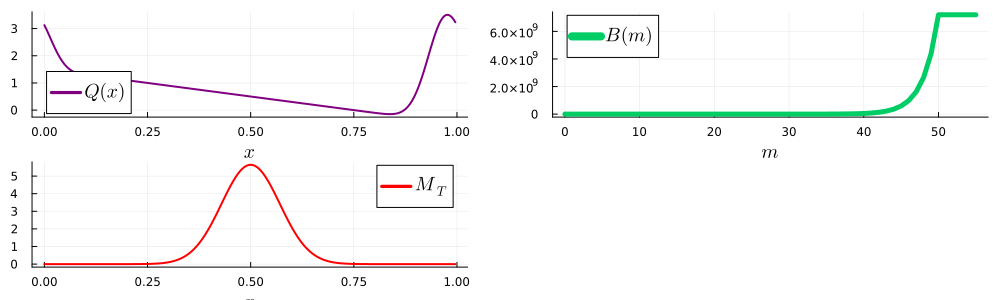

In [3]:
# Plot functions 
using LinearAlgebra, Plots, LaTeXStrings;

M_demo = 0:1:55

C_Q = 0.1
C_B = 1
Q_vec = C_Q * Q(x_grid, δ)
B_vec = C_B * B.(M_demo, 2 - 0)

p1 = plot(x_grid, Q_vec, label=L"Q(x)", color=:purple, lw=2, xlabel=L"x", bottom_margin=1Plots.mm, size=(500, 300), legendfontsize=13, labelfontsize=13)
p2 = plot(M_demo, B_vec, label=L"B(m)", color=:springgreen3, lw=5,  xlabel=L"m", bottom_margin=1Plots.mm, size=(500, 300),  labelfontsize=13, legendfontsize=13)
p3=plot(x_grid, M_T, label=L"M_T", color=:red, lw=2, xlabel=L"x", bottom_margin=1Plots.mm, size=(500, 300), legendfontsize=13, labelfontsize=13)
plot(p1, p2, p3, layout=3, size=(1000, 300))

In [2]:
using DelimitedFiles;
using JSON
using DelimitedFiles;
using Plots, LaTeXStrings;
using Printf


function read_run_results(run_number)
    U_list = []
    M_list = []
    run="new_crowdcrush_runs/run"*string(run_number)
    params = JSON.parsefile(run*"_params.json")
    Δt = params["Δt"]
    for h in params["h_list"]
        push!(U_list, readdlm(run*"_U_mat_conv_h$(h)_deltat$(Δt).csv", ','))
        push!(M_list, readdlm(run*"_M_mat_conv_h$(h)_deltat$(Δt).csv", ','))
    end
    return params, U_list, M_list
end

function read_run_iterations(run_number, h)
    U_iter_list = []
    M_iter_list = []
    run="new_crowdcrush_runs/run"*string(run_number)
    params = JSON.parsefile(run*"_params.json")
    Δt = params["Δt"]
    #if h ∉ params["h_list"] 
    #    println("h not in h_list")
    #    return
    #end
    # Find all files for this run
    files = readdir("new_crowdcrush_iteration_plots")
    
    iter_numbers = Int[]

    for f in files
        if occursin("run$(run_number)_iter", f) && occursin("M_mat_conv_h$(h)", f)
            m =  match(r"_iter(\d+)", f)
            if m !== nothing
                push!(iter_numbers, parse(Int, m.captures[1]))
            end
        end
    end
    println("iter_numbers: ", iter_numbers)
    iter_folder="new_crowdcrush_iteration_plots/run"*string(run_number)
    final_iter = maximum(iter_numbers)
    for iter in 0:final_iter
        push!(U_iter_list, readdlm(iter_folder*"_iter$(iter)_U_mat_conv_h$(h)_deltat$(Δt).csv", ','))
        push!(M_iter_list, readdlm(iter_folder*"_iter$(iter)_M_mat_conv_h$(h)_deltat$(Δt).csv", ','))
    end
    return params, U_iter_list, M_iter_list, final_iter
end


#PLOT RESULTS

function plot_results(run_number, h_start=1, h_end=-1, save_figures=false)
    params, U_list, M_list = read_run_results(run_number)
    (h_list, α, x_l, x_r, Δt, t_0, T, ν, num_it_MFG, num_it_HJB, δ, R) = (params["h_list"], params["α"], params["x_l"], params["x_r"], params["Δt"], params["t_0"], params["T"], params["ν"], params["num_it_MFG"], params["num_it_HJB"],  params["δ"], params["R"])
    
    if h_end==-1
        h_end=length(h_list)
    end
    println("Plot results for run number: ", run_number) 
    println("!!")
    println("parameters: ", params)
    println("size(U_list): ", size(U_list))
    flush(stdout)
    for (i,h) in enumerate(h_list[h_start:h_end])
        println("----")
        println("i: ", i)
        x_vec = x_l:h:(x_r-h);
        N_h =length(x_vec);
        t_vec = t_0:Δt:(T-Δt)
        N_T =length(t_vec)
        println("x_vec: ", x_vec)
        println("N_h: ", N_h)
        println("t_vec: ", t_vec)
        println("N_T: ", N_T)

        x_reverse_plot = false
        if x_reverse_plot        
            plot_U_mat = transpose(reverse(transpose(U_list[i]), dims=2));
            plot_M_mat = transpose(reverse(transpose(M_list[i]), dims=2));
        else 
            plot_U_mat = (U_list[i]);
            plot_M_mat = (M_list[i]);
        end

        println("SUM: ", sum(plot_M_mat[:,end]*h))
        
        zticks1 = 5:5:20
        p1 = plot(t_vec, x_vec, plot_M_mat, ylabel=L"x", xlabel=L"t",  st=:surface, labelfontsize=15, zlim=(0,50),
        color=cgrad(:cool, rev=false), size=(500, 500), xlim=(0,t_vec[end]), ylim=(0.1,0.9), legend=false, camera=(90- 20, 20), xflip=true, zticks=zticks1, title=L"m(x,t)")
        zticks2 = 0.5:0.5:4
        p2 = plot(t_vec, x_vec, plot_U_mat, xlabel=L"t", ylabel=L"x",   st=:surface, labelfontsize=15,
        color=:cividis, size=(500, 500), xlim=(0,t_vec[end]), zlim=(0, 4), legend=false, camera=(90- 20, 40), xflip=true, zticks=zticks2, title=L"u(x,t)",  ylim=(0, 1))

        # Save plots as PDF with h in the filename
        if save_figures
            run="run"*string(run_number)
            if x_reverse_plot
                savefig(p1, joinpath("figures",run*"_plot_new_M_h$(h)_deltat$(Δt).pdf"))
                savefig(p2, joinpath("figures",run*"_plot_new_U_h$(h)_deltat$(Δt).pdf"))
            else 
                savefig(p1, joinpath("figures",run*"_plot_new_M_h$(h)_deltat$(Δt)_not_rev.pdf"))
                savefig(p2, joinpath("figures",run*"_plot_new_U_h$(h)_deltat$(Δt)_not_rev.pdf"))
            end
        end 
        p = plot(p1, p2, layout=2, size=(600, 300), title="h="*string(h), titlefontsize=10)
        println("Display:") 
        display(p)
        # println("i: ", i)
        # if i==1
        #     break
        # end
        println("!!!!!!!!!")
    end
end


function plot_iterations(run_number, h, save_figures=false)
    params, U_list, M_list, final_iter = read_run_iterations(run_number, h)
    (h_list, α, x_l, x_r, Δt, t_0, T, ν, num_it_MFG, num_it_HJB, δ, R) = (params["h_list"], params["α"], params["x_l"], params["x_r"], params["Δt"], params["t_0"], params["T"], params["ν"], params["num_it_MFG"], params["num_it_HJB"],  params["δ"], params["R"])
    
    println("Plot results for run number: ", run_number) 
    println("Plot iterations from h=",h)
    println("!!")
    println("parameters: ", params)
    sleep(1)
    println("size(U_list): ", size(U_list))
    flush(stdout)

    final_iter = #largest iteration for this run number and this h.
    for i in 0:final_iter
        #println("----")
        #println("i: ", i)
        x_vec = x_l:h:(x_r-h);
        N_h =length(x_vec);
        t_vec = t_0:Δt:(T-Δt)
        N_T =length(t_vec)
        #println("x_vec: ", x_vec)
        #println("N_h: ", N_h)
        #println("t_vec: ", t_vec)
        #println("N_T: ", N_T)

        plot_U_mat = transpose(reverse(transpose(U_list[i+1]), dims=2));
        plot_M_mat = transpose(reverse(transpose(M_list[i+1]), dims=2));

        #println("i: ", i, "SUM: ", sum(plot_M_mat[:,end]*h))
        
        zticks1 = 5:5:20
        p1 = plot(t_vec, x_vec, plot_M_mat, ylabel=L"x", xlabel=L"t",  st=:surface, labelfontsize=15, zlim=(0,50),
        color=cgrad(:cool, rev=false), size=(500, 500), xlim=(0,t_vec[end]), ylim=(0.1,0.9), legend=false, camera=(90- 20, 20), xflip=true, zticks=zticks1, title=L"m(x,t)")
        zticks2 = 0.5:0.5:4
        p2 = plot(t_vec, x_vec, plot_U_mat, xlabel=L"t", ylabel=L"x",   st=:surface, labelfontsize=15,
        color=:cividis, size=(500, 500), xlim=(0,t_vec[end]), zlim=(0, 4), legend=false, camera=(90- 20, 40), xflip=true, zticks=zticks2, title=L"u(x,t)",  ylim=(0, 1))

        # Save plots as PDF with h in the filename
        if save_figures
            savefig(p1, joinpath("figures",run*"_plot_new_M_h$(h)_deltat$(Δt).pdf"))
            savefig(p2, joinpath("figures",run*"_plot_new_U_h$(h)_deltat$(Δt).pdf"))
        end 
        p = plot(p1, p2, layout=2, size=(600, 300), title="iter"*string(i)*"_h="*string(h), titlefontsize=10)
        #println("Display:") 
        display(p)
        # println("i: ", i)
        # if i==1
        #     break
        # end
        #println("!!!!!!!!!")
    end
end



#PLOT RESULTS AT FINAL TIME

function plot_final_time_results(run_number, h_start=1, h_end=-1,  save_figures=false)
    params, U_list, M_list = read_run_results(run_number)
    (h_list, α, x_l, x_r, Δt, t_0, T, ν, num_it_MFG, num_it_HJB, δ, R) = (params["h_list"], params["α"], params["x_l"], params["x_r"], params["Δt"], params["t_0"], params["T"], params["ν"], params["num_it_MFG"], params["num_it_HJB"],  params["δ"], params["R"])
    
    if h_end==-1
        h_end = length(h_list)
    end
    println("FINAL TIME PLOTS")
    println("Plot results for run number: ", run_number) 
    println("!!")
    println("parameters: ", params)
    println("size(U_list): ", size(U_list))
    flush(stdout)
    for (i,h) in enumerate(h_list[h_start: h_end])
        println("----")
        println("i: ", i)
        x_vec = x_l:h:(x_r-h);
        N_h =length(x_vec);
        t_vec = t_0:Δt:(T-Δt)
        N_T =length(t_vec)
        println("x_vec: ", x_vec)
        println("N_h: ", N_h)
        println("t_vec: ", t_vec)
        println("N_T: ", N_T)

        ###################################
        time_index = div(length(t_vec),1)
        println("time_index: ", time_index)

        plot_U_mat_final = U_list[i][:,1];
        plot_M_mat_final = M_list[i][:,time_index];
        plot_U_mat_first = U_list[i][:,time_index];
        plot_M_mat_first = M_list[i][:,1];

        p1 = plot(x_vec, plot_M_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="M, h="*string(h)*", t="*string(t_vec[time_index]),
        color=cgrad(:cool, rev=false), size=(500, 500), legend=false) #, xlim=(0,1) )
        #zticks2 = 0.5:0.5:4
        p2 = plot(x_vec, plot_U_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="U, h="*string(h)*", t="*string(t_vec[1]),
        color=:cividis, size=(500, 500), legend=false) #,xlim=(0, 1),)

        p3 = plot(x_vec, plot_M_mat_first, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="M, h="*string(h)*", t="*string(t_vec[1]),
        color=cgrad(:cool, rev=false), size=(500, 500), legend=false) #, xlim=(0,1) )
        #zticks2 = 0.5:0.5:4
        
        p4 = plot(x_vec, plot_U_mat_first, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="U, h="*string(h)*", t="*string(t_vec[time_index]),
        color=:cividis, size=(500, 500), legend=false) #,xlim=(0, 1),)

        if save_figures
            savefig(p1, joinpath("figures",run*"_final_time_plot_final_M_h$(h)_deltat$(Δt).pdf"))
            savefig(p2, joinpath("figures",run*"_final_time_plot_final_U_h$(h)_deltat$(Δt).pdf"))
            savefig(p3, joinpath("figures",run*"_final_time_plot_first_M_h$(h)_deltat$(Δt).pdf"))
            savefig(p4, joinpath("figures",run*"_final_time_plot_first_U_h$(h)_deltat$(Δt).pdf"))
        end
        p = plot(p1, p2, p3, p4, layout=4, size=(600, 600), titlefontsize=10)
        println("Display:")
        display(p)
        # println("i: ", i)
        # if i==1
        #     break
        # end
        println("!!!!!!!!!")
    end
end

#PLOT RESULTS AT FINAL TIME

function plot_final_time_iterations(run_number, h)
       params, U_list, M_list, final_iter = read_run_iterations(run_number, h)
    (h_list, α, x_l, x_r, Δt, t_0, T, ν, num_it_MFG, num_it_HJB, δ, R) = (params["h_list"], params["α"], params["x_l"], params["x_r"], params["Δt"], params["t_0"], params["T"], params["ν"], params["num_it_MFG"], params["num_it_HJB"],  params["δ"], params["R"])
    
    println("Plot results for run number: ", run_number) 
    println("Plot iterations from h=",h)
    println("!!")
    println("parameters: ", params)
    println("size(U_list): ", size(U_list))
    flush(stdout)
    final_iter = #largest iteration for this run number and this h.
    for i in 0:final_iter
        #println("----")
        #println("i: ", i)
        x_vec = x_l:h:(x_r-h);
        N_h =length(x_vec);
        t_vec = t_0:Δt:(T-Δt)
        N_T =length(t_vec)
        #println("x_vec: ", x_vec)
        #println("N_h: ", N_h)
        #println("t_vec: ", t_vec)
        #println("N_T: ", N_T)

        plot_U_mat = transpose(reverse(transpose(U_list[i+1]), dims=2));
        plot_M_mat = transpose(reverse(transpose(M_list[i+1]), dims=2));

        ###################################
        time_index = div(length(t_vec),1)
        println("time_index: ", time_index)

        plot_U_mat_final = U_list[i+1][:,1];
        plot_M_mat_final = M_list[i+1][:,time_index];
        plot_U_mat_first = U_list[i+1][:,time_index];
        plot_M_mat_first = M_list[i+1][:,1];

        p1 = plot(x_vec, plot_M_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="M, h="*string(h)*", t="*string(t_vec[time_index]),
        color=cgrad(:cool, rev=false), size=(500, 500), legend=false) #, xlim=(0,1) )
        #zticks2 = 0.5:0.5:4
        p2 = plot(x_vec, plot_U_mat_final, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="U, h="*string(h)*", t="*string(t_vec[1]),
        color=:cividis, size=(500, 500), legend=false) #,xlim=(0, 1),)

        p3 = plot(x_vec, plot_M_mat_first, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="M, h="*string(h)*", t="*string(t_vec[1]),
        color=cgrad(:cool, rev=false), size=(500, 500), legend=false) #, xlim=(0,1) )
        #zticks2 = 0.5:0.5:4
        
        p4 = plot(x_vec, plot_U_mat_first, xlabel=L"x", ylabel=L"y", labelfontsize=10,title="U, h="*string(h)*", t="*string(t_vec[time_index]),
        color=:cividis, size=(500, 500), legend=false) #,xlim=(0, 1),)

        p = plot(p1, p2, p3, p4, layout=4, size=(600, 600), title="iter"*string(i)*"_h="*string(h), titlefontsize=10)
        println("Display:")
        display(p)
        # println("i: ", i)
        # if i==1
        #     break
        # end
        println("!!!!!!!!!")
    end
end

plot_final_time_iterations (generic function with 1 method)

iter_numbers: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Plot results for run number: 4
Plot iterations from h=0.0009765625
!!
parameters: Dict{String, Any}("T" => 2, "δ" => 0.05, "x_l" => 0, "h_list" => Any[0.0009765625], "x_r" => 1, "C_H" => 0.1, "ν" => 0.1, "α" => 1.5, "num_it_HJB" => 20, "Δt" => 0.01, "num_it_MFG" => 50, "R" => 30, "t_0" => 0)
size(U_list): (9,)


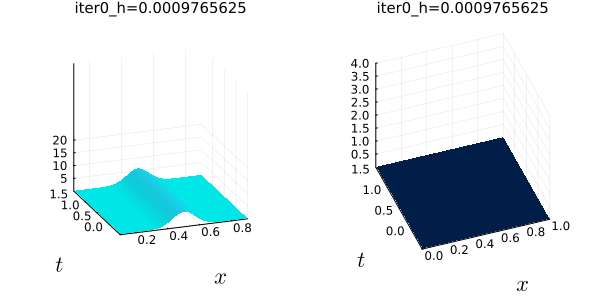

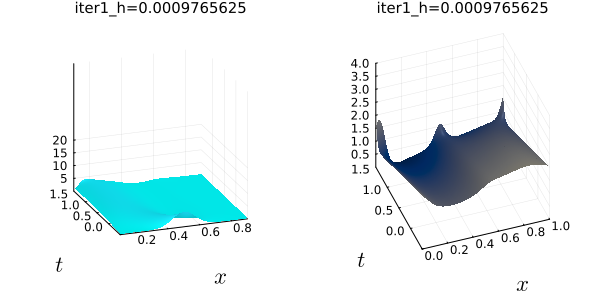

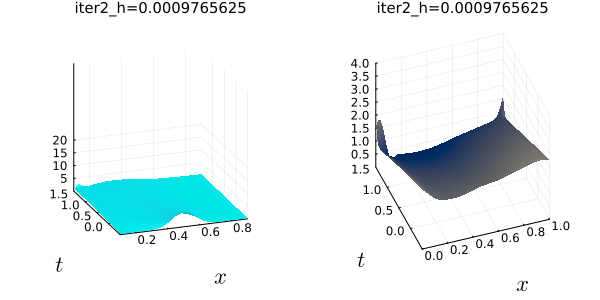

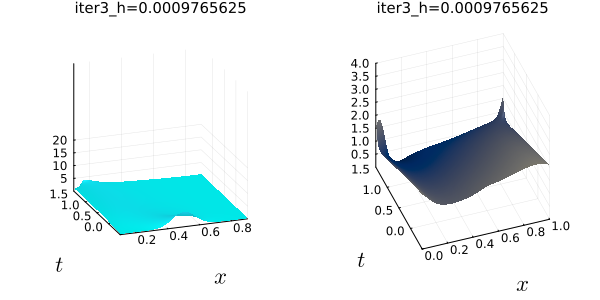

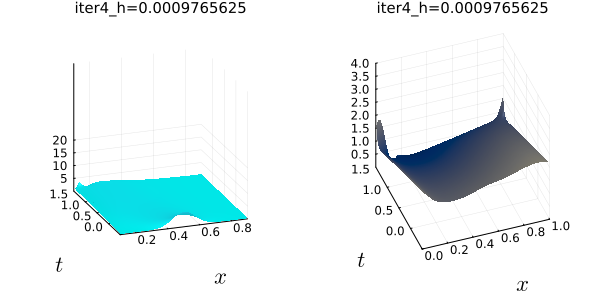

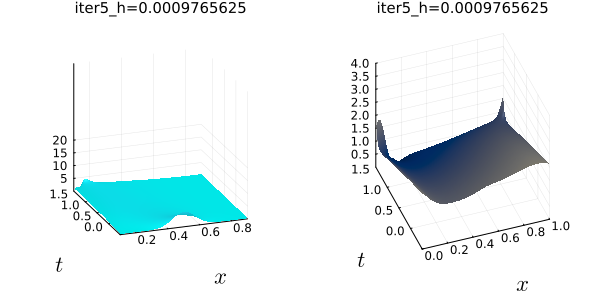

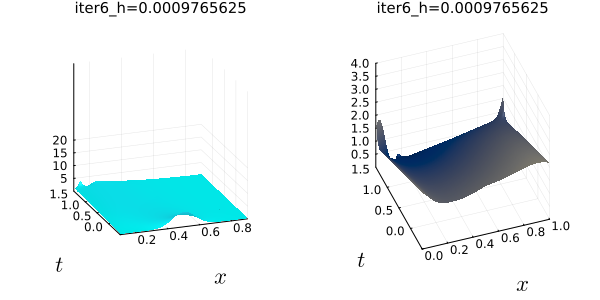

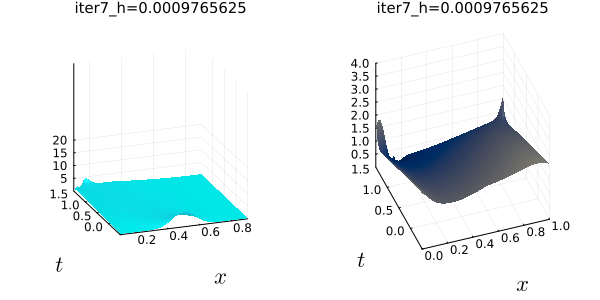

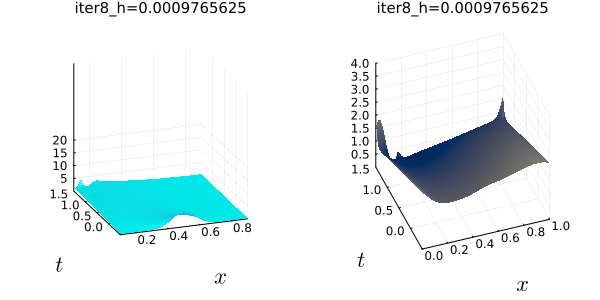

In [5]:
plot_iterations(4,0.0009765625)

iter_numbers: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Plot results for run number: 4
Plot iterations from h=0.0009765625
!!
parameters: Dict{String, Any}("T" => 2, "δ" => 0.05, "x_l" => 0, "h_list" => Any[0.0009765625], "x_r" => 1, "C_H" => 0.1, "ν" => 0.1, "α" => 1.5, "num_it_HJB" => 20, "Δt" => 0.01, "num_it_MFG" => 50, "R" => 30, "t_0" => 0)
size(U_list): (9,)
time_index: 200
Display:
!!!!!!!!!
time_index: 200
Display:
!!!!!!!!!
time_index: 200
Display:
!!!!!!!!!
time_index: 200
Display:
!!!!!!!!!
time_index: 200
Display:
!!!!!!!!!
time_index: 200
Display:
!!!!!!!!!
time_index: 200
Display:
!!!!!!!!!
time_index: 200
Display:
!!!!!!!!!
time_index: 200
Display:
!!!!!!!!!


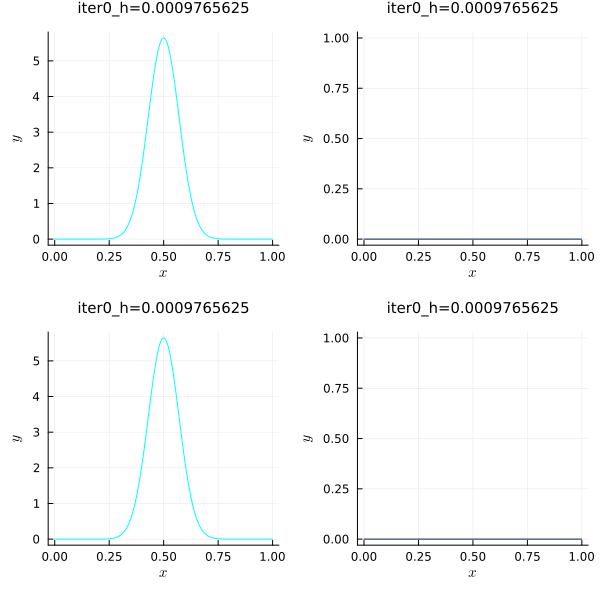

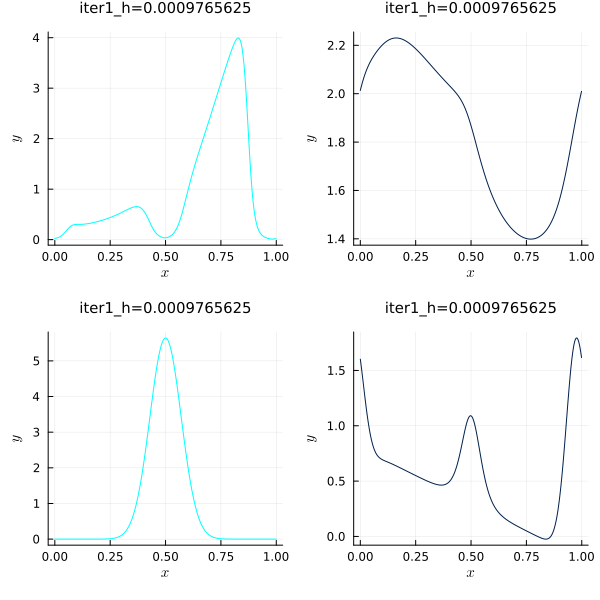

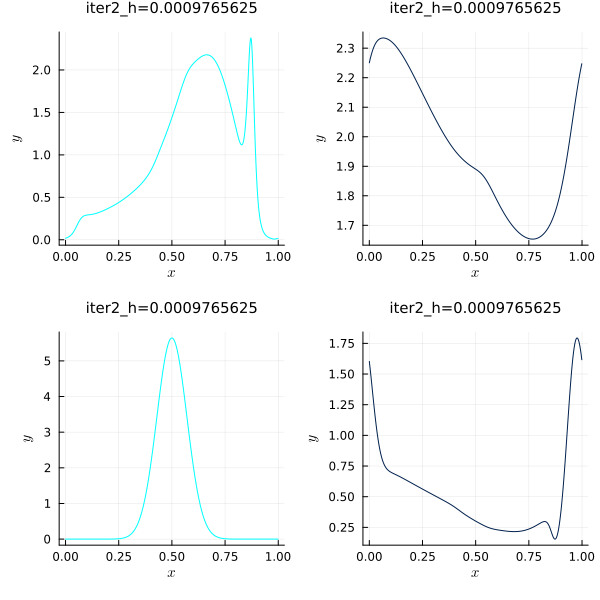

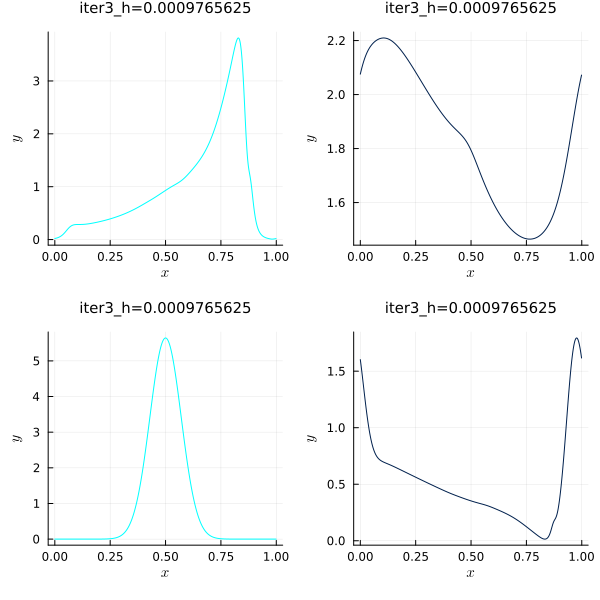

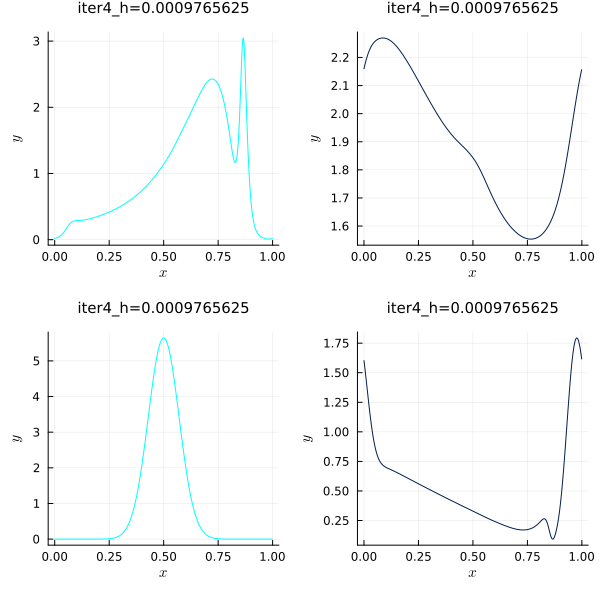

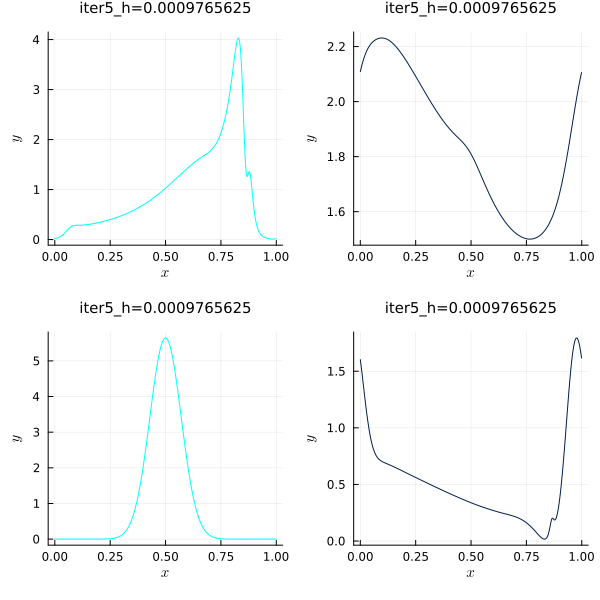

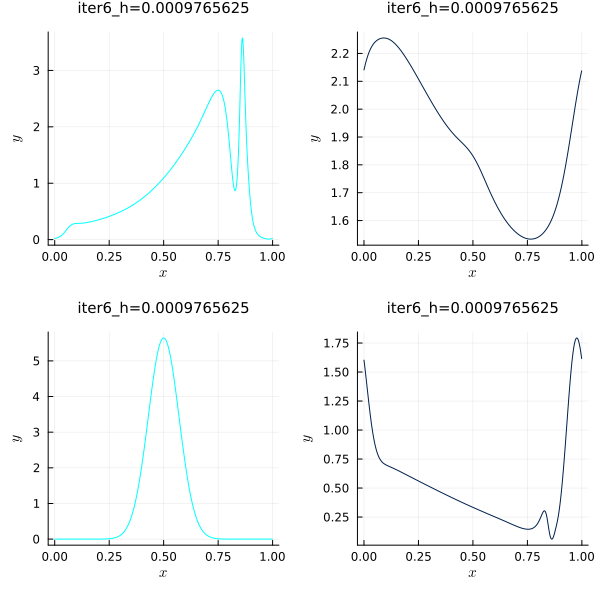

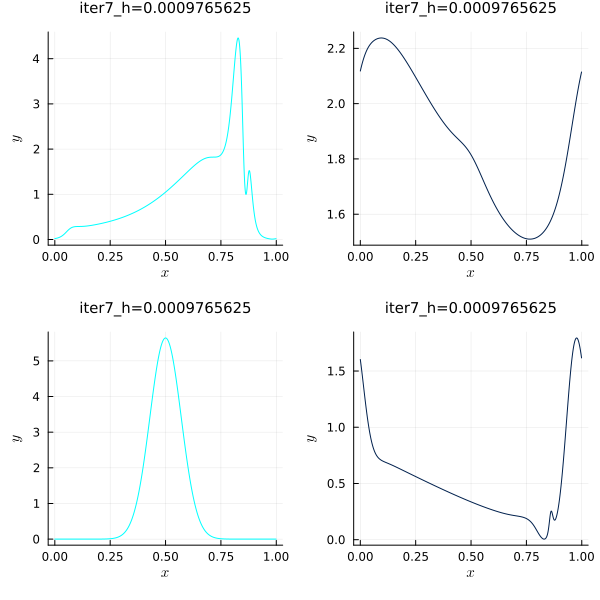

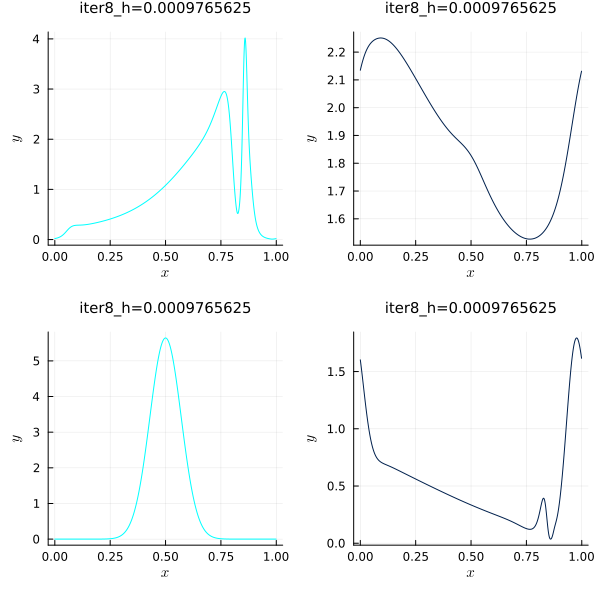

In [6]:
plot_final_time_iterations(4,0.0009765625)